In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class_names = ['ant', 'axe', 'bear', 'bee', 'nose']
num_classes = 5
img_size = 28
batch_size = 32
samples_per_class = 5000

In [3]:
def load_data(class_names, samples_per_class):
    images = []
    labels = []
    
    for idx, class_name in enumerate(class_names):
        data = np.load(f'dataset/full_numpy_bitmap_{class_name}.npy')
        data = data[:samples_per_class] 
        images.append(data)
        labels.extend([idx] * len(data))
    
    images = np.concatenate(images, axis=0)
    images = images.reshape(-1, 28, 28, 1)
    labels = np.array(labels)
    
    return images, labels

In [4]:
images, labels = load_data(class_names, samples_per_class)

In [5]:
images.shape

(25000, 28, 28, 1)

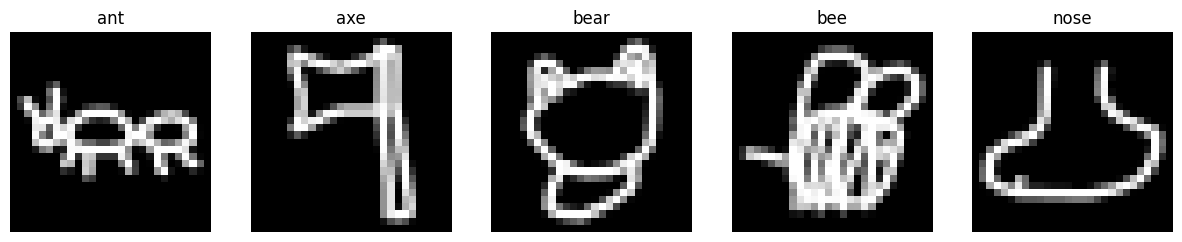

In [6]:
# lets look at the first image of each class
plt.figure(figsize=(15, 3))
for i in range(5):
    idx = np.where(labels == i)[0][0]     
    plt.subplot(1, 5, i+1)
    plt.imshow(images[idx].squeeze(), cmap='gray')  
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

images = images.astype('float32') / 255.0 #normalizw

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
from tensorflow import keras

In [9]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 127.5 - 1.0, label


In [10]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(
        factor=0.15,  
        fill_mode='constant',
        fill_value=0.0  
    ),
    layers.RandomZoom(
        height_factor=(-0.1, 0.2),  
        width_factor=(-0.1, 0.2),
        fill_mode='constant'
    ),
    layers.RandomContrast(factor=0.15),  
    layers.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='constant'
    )
])

In [11]:
def create_dataset(images, labels, batch_size=32, augment=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),  
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [12]:
batch_size = 64
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, augment=False)

In [29]:
def plot_augmented_images(dataset, class_names, n_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 3))
        for i in range(n_images):
            plt.subplot(1, n_images, i+1)
            img = (images[i].numpy() + 1.0) * 127.5 # denormalize
            plt.imshow(img, cmap='gray')
            plt.title(class_names[labels[i].numpy()])
            plt.axis('off')
        plt.show()

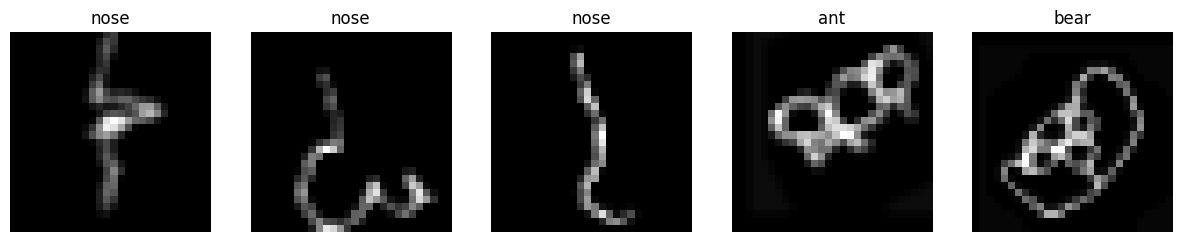

In [28]:
plot_augmented_images(train_dataset, class_names)